In [1]:
import pandas as pd
SAVE_DIR= '../data'
data_imgs_text = pd.read_csv(f"{SAVE_DIR}/coco_imgs_text_balanced_val.csv")

In [2]:
# Test for smaller samples
SIZE = 10
LEN = data_imgs_text.shape[0]
data_imgs_text = data_imgs_text.sample(frac  = SIZE/LEN, random_state=42)

In [3]:
data_imgs_text

modality                                              input  label  \
361    image                   ../data/val2017/000000225670.jpg      1   
73      text       A small bird sitting on top of an open book.      0   
374    image                   ../data/val2017/000000542089.jpg      1   
155     text  Three zebras standing together in a grassy field.      0   
104    image                   ../data/val2017/000000335427.jpg      1   
394     text  An apple tree is shown in the middle of an orc...      0   
377    image                   ../data/val2017/000000250619.jpg      1   
124     text  a long disk with several laptops and PC comput...      0   
68     image                   ../data/val2017/000000539445.jpg      1   
450     text      a black brown and white dog with a red collar      0   

            file_name  
361  000000225670.jpg  
73   000000542776.jpg  
374  000000542089.jpg  
155  000000546011.jpg  
104  000000335427.jpg  
394  000000044260.jpg  
377  000000250619.jpg  
124  000000547144.jpg  
68   000000539445.jpg  
450  000000364636.jpg

In [4]:
texts, text_labels  = data_imgs_text[data_imgs_text.modality == 'text'].input.tolist(), data_imgs_text[data_imgs_text.modality == 'text'].label.tolist() 
filenames, filenames_labels = data_imgs_text[data_imgs_text.modality == 'image'].file_name.tolist(), data_imgs_text[data_imgs_text.modality == 'image'].label.tolist()
print(len(texts), len(filenames))

5 5


# probing

In [5]:
# loading
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration
from transformers import PaliGemmaForConditionalGeneration
import torch, random
import numpy as np

import random
def seed_everywhere(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)   
    
seed_everywhere(42)
device = "cuda:1"
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "google/paligemma2-3b-pt-224", 
    trust_remote_code=True,
    torch_dtype=torch.float32,  # Use fp16 for memory efficiency
    device_map=None  # We'll handle device placement manually
)
model = model.to(device)
language_model = model.language_model
tokenizer = AutoTokenizer.from_pretrained("google/paligemma2-3b-pt-224", use_fast=True)

/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]


In [6]:
# read imgs
from contextlib import nullcontext
from PIL import Image
from transformers import AutoTokenizer, AutoProcessor
import concurrent.futures
import os, io, concurrent.futures

IMG_ROOT = "../data/coco_imgs_text_cls_imgs" 

def _read_bytes(path: str) -> bytes:
    with open(path, "rb") as f:
        return f.read()
    
def _amp_ctx(device, use_amp=True):
    """Return a context manager for autocast if on CUDA, else a no-op."""
    if not use_amp:
        return nullcontext()
    is_cuda = torch.cuda.is_available() and (
        str(device).startswith("cuda") or getattr(getattr(device, "type", None), "__str__", lambda: "")() == "cuda"
        or (hasattr(device, "type") and device.type == "cuda")
    )
    if not is_cuda:
        return nullcontext()
    # Prefer new API if available
    try:
        return torch.autocast("cuda", dtype=torch.float16)
    except Exception:
        # Fallback for older PyTorch
        return torch.cuda.amp.autocast(dtype=torch.float16)
    
IMG_EXTS = (".jpg", ".jpeg", ".png", ".webp")

def get_acts_paligemma(
    model, device,
    model_name='google/paligemma2-3b-pt-224',
    *,
    filenames=None, img_byte_cache=None, text=None,
    batch_size=32, use_amp=True,
    mode="lm",  # "raw"=raw towers 1152, "lm"=language model space 2304
    # There is actually no use to get raw towers since that's not we are interested in
    pad_to_max=258   # int: pad/truncate text to fixed length (e.g., 64, the same length as an image in gemma). None = variable length
):
    """
    Extract hidden states from PaliGemma.
    
    Args:
        model: the loaded PaliGemma model
        device: GPU/CPU device
        model_name: HF model name
        filenames: list of image filenames (if using images)
        img_byte_cache: dict {filename: bytes} for image loading
        text: list of text strings (if using text)
        batch_size: minibatch size
        use_amp: whether to use autocast
        mode: "raw" for raw tower outputs (1152),
              "lm" for language-model space (2304)
    
    Returns:
        np.ndarray of hidden states concatenated across batches.
         
    """
    if text and filenames: 
        raise ValueError("Provide either text or image, not both.")
    
    feats = []
    model.eval()
    
    # ---------------- IMAGE branch ----------------
    if filenames is not None:
        assert img_byte_cache is not None, "Need img_byte_cache for image path mode"
        proc = AutoProcessor.from_pretrained(model_name)
        if mode == "raw":
            model.vision_tower.config.output_hidden_states = True
        else:
            model.language_model.config.output_hidden_states = True

        with torch.inference_mode(), _amp_ctx(device, use_amp):
            for start in range(0, len(filenames), batch_size):
                fnb = filenames[start:start+batch_size]
                imgs = [Image.open(io.BytesIO(img_byte_cache[fn])).convert("RGB") for fn in fnb]

                if mode == "raw": # Vision tower's internals we don't care, so actually this branch is never used
                    enc = proc(images=imgs, text=["<image>"]*len(imgs), return_tensors="pt")
#                     enc = proc(images=imgs, return_tensors="pt").to(device) 
                    px = enc["pixel_values"].to(device, non_blocking=True)
                    vout = model.vision_tower(pixel_values=px, output_hidden_states=True, return_dict=True)
                    hs = vout.hidden_states  # tuple of (layers) [B, seq, 1152]
                else:  # LM mode (image tokens projected → 2304)
                    enc = proc(images=imgs, text=["<image>"]*len(imgs), return_tensors="pt").to(device) # Will the "<image>" tokens tell the linear probes this is an image?
#                     enc = proc(images=imgs, return_tensors="pt").to(device) 
                    out = model(**enc, output_hidden_states=True, return_dict=True)
                    hs = out.hidden_states  # tuple of (layers) [B, seq, 2304]

                feats.append([h.detach().cpu().float().numpy() for h in hs])
                del hs, enc, imgs
                torch.cuda.empty_cache()
    
    # ---------------- TEXT branch ----------------
    elif text is not None:
        tok = AutoTokenizer.from_pretrained(model_name)
        model.language_model.config.output_hidden_states = True

        with torch.inference_mode(), _amp_ctx(device, use_amp):
            for start in range(0, len(text), batch_size):
                tbatch = text[start:start+batch_size]
                enc = tok(
                    tbatch,
                    return_tensors="pt",
                    padding="max_length" if pad_to_max else True,
                    truncation=True,
                    max_length=pad_to_max
                ).to(device)

                out = model.language_model(**enc, output_hidden_states=True, return_dict=True)
                hs = out.hidden_states  # tuple of (layers) [B, seq, 2304]

                feats.append([h.detach().cpu().float().numpy() for h in hs])
                del hs, enc, out
                torch.cuda.empty_cache()
    else:
        raise ValueError("Must provide either filenames or text.")

    # --- Reformat: concatenate batches along dim 0, preserve layers ---
    n_layers = len(feats[0])
    layerwise = []
    for l in range(n_layers):
        arrs = [batch[l] for batch in feats]
        layerwise.append(np.concatenate(arrs, axis=0))  # [N, pad_to_max, D] if fixed, else [N, seq, D]

    return layerwise

def preload_image_bytes(filenames, root, max_workers: int = 12):
    paths = [os.path.join(root, fn) for fn in filenames]
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as ex:
        data = list(ex.map(_read_bytes, paths))
    return dict(zip(filenames, data))

img_byte_cache = preload_image_bytes(filenames, IMG_ROOT, max_workers=12) if len(filenames) else None

In [7]:
with torch.inference_mode():
    img_acts = get_acts_paligemma(model, device = device, filenames=filenames, img_byte_cache=img_byte_cache)
    txt_acts = get_acts_paligemma(model, device = device, text=texts, )

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [8]:
len(img_acts), img_acts[0].shape  # [N, seq_len, n_hidd]

(27, (5, 258, 2304))

In [9]:
len(txt_acts), txt_acts[0].shape

(27, (5, 258, 2304))

## loop


=== LAYER 0 ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


=== LAYER 1 ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


=== LAYER 2 ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      

Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


=== LAYER 21 ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2


=== LAYER 22 ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Test F1:       1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1


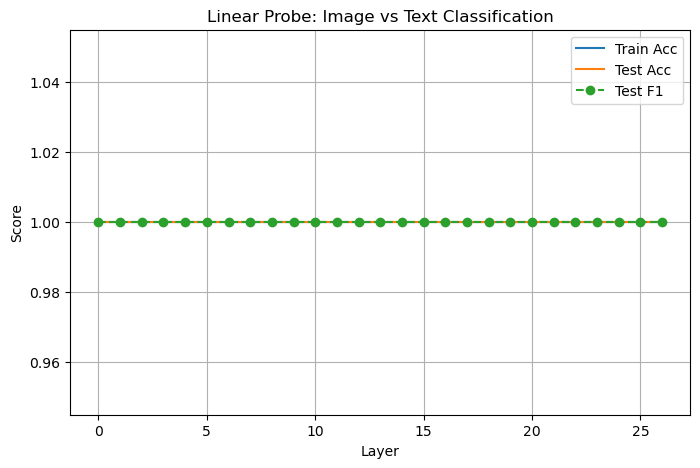

In [12]:
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd
import json

layer_to_test = list(range(27)) # including the layer 0 which is the residual for embedding layer 
all_results = []
PROBES_SAVE_DIR = '../models'
os.makedirs(PROBES_SAVE_DIR, exist_ok=True)
# ---- Extract activations ----
with torch.inference_mode():
    img_layers = get_acts_paligemma(
        model, device=device, filenames=filenames,
        img_byte_cache=img_byte_cache, mode="lm", pad_to_max=64
    )
    txt_layers = get_acts_paligemma(
        model, device=device, text=texts, mode="lm", pad_to_max=64
    )
        
for layer in layer_to_test:
    print(f"\n=== LAYER {layer} ===")

    # select this layer’s activations and pool
    img_hs = img_layers[layer]   # [N_img, seq, D]
    txt_hs = txt_layers[layer]   # [N_txt, seq, D]
    img_vecs = img_hs.mean(axis=1)  # [N_img, D]
    txt_vecs = txt_hs.mean(axis=1)  # [N_txt, D]

    # ---- Prepare dataset ----
    X = np.concatenate([txt_vecs, img_vecs], axis=0)
    y = np.array([0]*len(txt_vecs) + [1]*len(img_vecs))

    # ---- Train/test split ----
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    

    model_info = {
        "coef": clf.coef_.tolist(),
        "intercept": clf.intercept_.tolist(),
        "classes": clf.classes_.tolist(),
        "params": clf.get_params()
    }

    with open(os.path.join(PROBES_SAVE_DIR,f"clf_img_text_layer{layer}.json"), "w") as f:
        json.dump(model_info, f)

    y_pred_train, y_pred_test = clf.predict(X_train), clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average="macro")
    report = classification_report(y_test, y_pred_test, output_dict=False)

    results = {
        "layer": layer,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "test_f1": test_f1,
        "report": report
    }
    all_results.append(results)

    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test F1:       {test_f1:.4f}")
    print(report)

# ---- Save results ----
os.makedirs(f"../figs_tabs/img_txt_cls_{SIZE}", exist_ok=True)
df = pd.DataFrame([
    {"layer": r["layer"], "train_acc": r["train_acc"],
     "test_acc": r["test_acc"], "test_f1": r["test_f1"]}
    for r in all_results
])
df.to_csv(f"../figs_tabs/img_txt_cls/results_{SIZE}.csv", index=False)

# ---- Plot ----
plt.figure(figsize=(8,5))
plt.plot(df["layer"], df["train_acc"], label="Train Acc")
plt.plot(df["layer"], df["test_acc"], label="Test Acc")
plt.plot(df["layer"], df["test_f1"], label="Test F1", linestyle="--", marker="o")
plt.xlabel("Layer")
plt.ylabel("Score")
plt.title("Linear Probe: Image vs Text Classification")
plt.legend()
plt.grid(True)
plt.savefig(f"../figs_tabs/img_txt_cls/accuracy_f1_curve_{SIZE}.png", dpi=150)
plt.show()
plt.close()


In [ ]:
import json
import numpy as np
from sklearn.linear_model import LogisticRegression
# how to read saved clfs
clfs = {}
for layer in layer_to_test:
    with open(os.path.join(PROBES_SAVE_DIR,f"clf_img_text_layer{layer}.json"), "w") as f:
        info = json.load(f)

    clf_new = LogisticRegression(**info["params"])
    clf_new.classes_ = np.array(info["classes"])
    clf_new.coef_ = np.array(info["coef"])
    clf_new.intercept_ = np.array(info["intercept"])
    clfs[layer] = (clf_new)